
# Comparing Linear Bayesian Regressors

This example compares two different bayesian regressors:

 - a `automatic_relevance_determination`
 - a `bayesian_ridge_regression`

In the first part, we use an `ordinary_least_squares` (OLS) model as a
baseline for comparing the models' coefficients with respect to the true
coefficients. Thereafter, we show that the estimation of such models is done by
iteratively maximizing the marginal log-likelihood of the observations.

In the last section we plot predictions and uncertainties for the ARD and the
Bayesian Ridge regressions using a polynomial feature expansion to fit a
non-linear relationship between `X` and `y`.


In [1]:
# Author: Arturo Amor <david-arturo.amor-quiroz@inria.fr>

## Models robustness to recover the ground truth weights

### Generate synthetic dataset

We generate a dataset where `X` and `y` are linearly linked: 10 of the
features of `X` will be used to generate `y`. The other features are not
useful at predicting `y`. In addition, we generate a dataset where `n_samples
== n_features`. Such a setting is challenging for an OLS model and leads
potentially to arbitrary large weights. Having a prior on the weights and a
penalty alleviates the problem. Finally, gaussian noise is added.



In [17]:
from sklearn.datasets import make_regression

X, y, true_weights = make_regression(
    n_samples=100,
    n_features=100,
    n_informative=10,
    noise=8,
    coef=True,
    random_state=42,
)


true_weights.shape

(100,)

### Bayesian Automatic Relevance Determination (ARD) Regression

#### Concept

Bayesian ARD Regression is a regression model that employs an Automatic Relevance Determination (ARD) prior to fit the weights. This model assumes that the weights are distributed according to Gaussian distributions, and it estimates the hyperparameters of these distributions using an iterative procedure called Evidence Maximization.

The ARD prior is useful for feature selection as it can prune irrelevant features by driving their corresponding weights to zero.

#### Mathematical Background

Given a dataset $\ \{X, y\} $:

- $\ X \in \mathbb{R}^{n \times p} $ is the design matrix with $\ n $ samples and $\ p $ features.
- $\ y \in \mathbb{R}^{n} $ is the target vector.

The model is defined as:

$\
y = X \beta + \epsilon
$

where:
- $\ \beta \in \mathbb{R}^{p} $ is the vector of weights.
- $\ \epsilon \sim \mathcal{N}(0, \alpha^{-1} I) $ is the noise term with precision $\ \alpha $.

Each weight $\ \beta_j $ is assumed to be Gaussian-distributed:

$\
\beta_j \sim \mathcal{N}(0, \lambda_j^{-1})
$

where $\ \lambda_j $ is the precision of the distribution of $\ \beta_j $.

The hyperparameters $\ \alpha $ and $\ \lambda $ are estimated using Gamma distributions:

$\
\alpha \sim \text{Gamma}(\alpha_1, \alpha_2)
$
$\
\lambda_j \sim \text{Gamma}(\lambda_1, \lambda_2)
$

The parameters are updated iteratively to maximize the evidence.

#### Logical Explanation

1. **Initialization**: Initialize the weights $\ \beta $ and the hyperparameters $\ \alpha $ and $\ \lambda $.

2. **Iterative Updates**:
   - Update the weights $\ \beta $ based on the current estimates of $\ \alpha $ and $\ \lambda $.
   - Update $\ \alpha $ based on the residuals of the model.
   - Update $\ \lambda $ based on the current estimates of the weights.

3. **Convergence**: Repeat the updates until the change in the weights $\ \beta $ is smaller than a predefined threshold (tol) or the maximum number of iterations (max_iter) is reached.


#### Advantages

- **Feature Selection**: ARD can automatically drive irrelevant feature weights to zero, effectively performing feature selection.
- **Probabilistic Interpretation**: Provides a probabilistic framework, allowing for the incorporation of prior knowledge and the estimation of uncertainty.
- **Regularization**: ARD imposes a regularization that can prevent overfitting, especially in high-dimensional spaces.

#### Disadvantages

- **Computational Complexity**: The iterative procedure can be computationally intensive, especially for large datasets.
- **Hyperparameter Sensitivity**: The performance of the model can be sensitive to the choice of hyperparameters.

#### Main Arguments

- **max_iter**: Maximum number of iterations. If `None`, defaults to 300.
- **tol**: Tolerance for convergence.
- **alpha_1**: Shape parameter for the Gamma distribution prior over \(\alpha\).
- **alpha_2**: Inverse scale parameter for the Gamma distribution prior over \(\alpha\).
- **lambda_1**: Shape parameter for the Gamma distribution prior over \(\lambda\).
- **lambda_2**: Inverse scale parameter for the Gamma distribution prior over \(\lambda\).
- **compute_score**: If True, compute the objective function at each step.
- **threshold_lambda**: Threshold for pruning weights with high precision.
- **fit_intercept**: Whether to calculate the intercept for the model.
- **copy_X**: If True, X will be copied; else, it may be overwritten.
- **verbose**: Verbose mode during model fitting.

### Fit the regressors

We now fit both Bayesian models and the OLS to later compare the models'
coefficients.



In [18]:
import pandas as pd

from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression

olr = LinearRegression().fit(X, y)
brr = BayesianRidge(compute_score=True, max_iter=30).fit(X, y)
ard = ARDRegression(compute_score=True, max_iter=30).fit(X, y)
df = pd.DataFrame(
    {
        "Weights of true generative process": true_weights,
        "ARDRegression": ard.coef_,
        "BayesianRidge": brr.coef_,
        "LinearRegression": olr.coef_,
    }
)
df

,Weights of true generative process,ARDRegression,BayesianRidge,LinearRegression
0,0.000000,-0.590226,-0.631933,3.443870
1,0.000000,-0.001504,-3.250621,-2.777989
2,0.000000,-0.000594,-2.509021,-4.784862
3,0.000000,-0.000171,2.541967,7.673019
4,32.125517,33.179873,34.489623,37.136375
...,...,...,...,...
95,0.000000,-0.000064,-6.270549,-12.263649
96,0.000000,0.000780,0.430155,0.550819
97,0.000000,-0.000342,1.065423,-0.541437
98,0.000000,0.001329,-0.771873,2.979917


### Plot the true and estimated coefficients

Now we compare the coefficients of each model with the weights of
the true generative model.



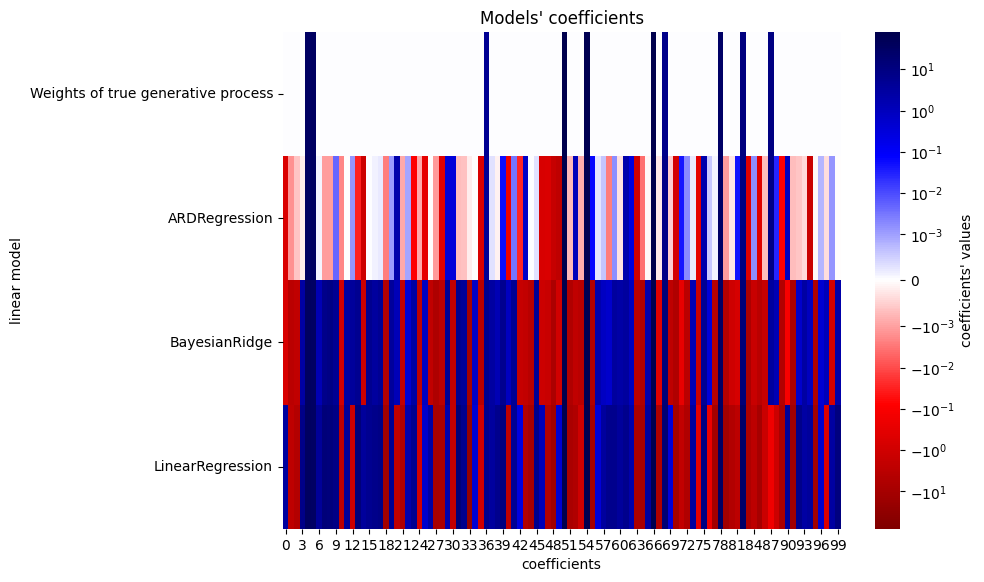

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-80, vmax=80),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.tight_layout(rect=(0, 0, 1, 0.95))
_ = plt.title("Models' coefficients")

Due to the added noise, none of the models recover the true weights. Indeed,
all models always have more than 10 non-zero coefficients. Compared to the OLS
estimator, the coefficients using a Bayesian Ridge regression are slightly
shifted toward zero, which stabilises them. The ARD regression provides a
sparser solution: some of the non-informative coefficients are set exactly to
zero, while shifting others closer to zero. Some non-informative coefficients
are still present and retain large values.



### Plot the marginal log-likelihood



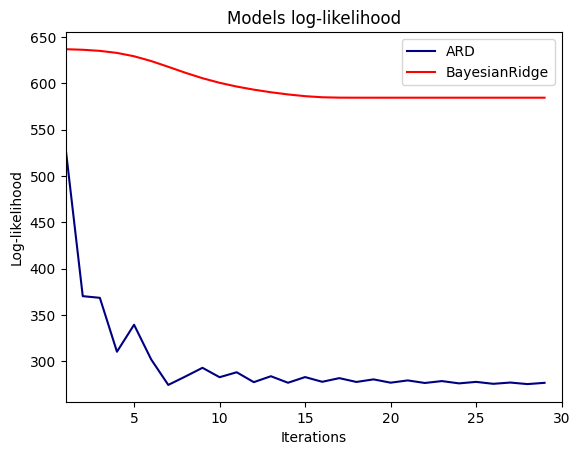

In [20]:
import numpy as np

ard_scores = -np.array(ard.scores_)
brr_scores = -np.array(brr.scores_)
plt.plot(ard_scores, color="navy", label="ARD")
plt.plot(brr_scores, color="red", label="BayesianRidge")
plt.ylabel("Log-likelihood")
plt.xlabel("Iterations")
plt.xlim(1, 30)
plt.legend()
_ = plt.title("Models log-likelihood")

Indeed, both models minimize the log-likelihood up to an arbitrary cutoff
defined by the `max_iter` parameter.

## Bayesian regressions with polynomial feature expansion
Generate synthetic dataset
--------------------------
We create a target that is a non-linear function of the input feature.
Noise following a standard uniform distribution is added.



In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

rng = np.random.RandomState(0)
n_samples = 110

# sort the data to make plotting easier later
X = np.sort(-10 * rng.rand(n_samples) + 10)
noise = rng.normal(0, 1, n_samples) * 1.35
y = np.sqrt(X) * np.sin(X) + noise
full_data = pd.DataFrame({"input_feature": X, "target": y})
X = X.reshape((-1, 1))

# extrapolation
X_plot = np.linspace(10, 10.4, 10)
y_plot = np.sqrt(X_plot) * np.sin(X_plot)
X_plot = np.concatenate((X, X_plot.reshape((-1, 1))))
y_plot = np.concatenate((y - noise, y_plot))

### Fit the regressors

Here we try a degree 10 polynomial to potentially overfit, though the bayesian
linear models regularize the size of the polynomial coefficients. As
`fit_intercept=True` by default for
:class:`~sklearn.linear_model.ARDRegression` and
:class:`~sklearn.linear_model.BayesianRidge`, then
:class:`~sklearn.preprocessing.PolynomialFeatures` should not introduce an
additional bias feature. By setting `return_std=True`, the bayesian regressors
return the standard deviation of the posterior distribution for the model
parameters.



In [27]:
ard_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    ARDRegression(),
).fit(X, y)
brr_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    BayesianRidge(),
).fit(X, y)

y_ard, y_ard_std = ard_poly.predict(X_plot, return_std=True)
y_brr, y_brr_std = brr_poly.predict(X_plot, return_std=True)

### Plotting polynomial regressions with std errors of the scores



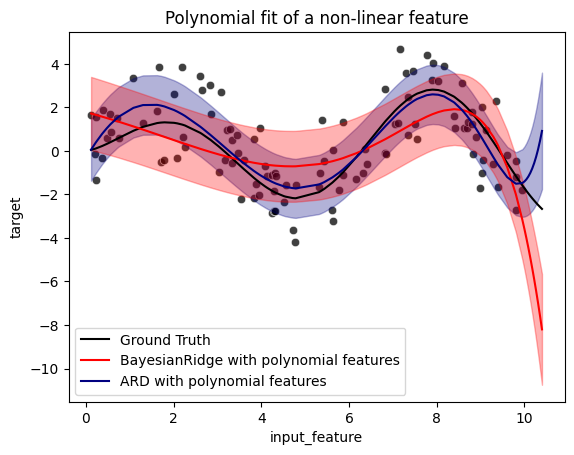

In [21]:
ax = sns.scatterplot(
    data=full_data, x="input_feature", y="target", color="black", alpha=0.75
)
ax.plot(X_plot, y_plot, color="black", label="Ground Truth")
ax.plot(X_plot, y_brr, color="red", label="BayesianRidge with polynomial features")
ax.plot(X_plot, y_ard, color="navy", label="ARD with polynomial features")
ax.fill_between(
    X_plot.ravel(),
    y_ard - y_ard_std,
    y_ard + y_ard_std,
    color="navy",
    alpha=0.3,
)
ax.fill_between(
    X_plot.ravel(),
    y_brr - y_brr_std,
    y_brr + y_brr_std,
    color="red",
    alpha=0.3,
)
ax.legend()
_ = ax.set_title("Polynomial fit of a non-linear feature")

The error bars represent one standard deviation of the predicted gaussian
distribution of the query points. Notice that the ARD regression captures the
ground truth the best when using the default parameters in both models, but
further reducing the `lambda_init` hyperparameter of the Bayesian Ridge can
reduce its bias (see example
`sphx_glr_auto_examples_linear_model_plot_bayesian_ridge_curvefit.py`).
Finally, due to the intrinsic limitations of a polynomial regression, both
models fail when extrapolating.

